Script sacado de https://www.tensorflow.org/tutorials/structured_data/time_series#convolution_neural_network

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.8.0
Pandas Version: 1.4.1
Numpy Version: 1.21.2
System Version: 3.8.13 (default, Mar 28 2022, 06:16:26) 
[Clang 12.0.0 ]


In [21]:
import IPython
import IPython.display

In [22]:
def create_time_steps(length):
    return list(range(-length, 0))

In [23]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

## Datos

Los datos son tomados del instituto Max Planck y corresponden a datos climáticos

In [5]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)
print("DataFrame Shape: {} rows, {} columns".format(*df.shape))
display(df.head())

DataFrame Shape: 420551 rows, 15 columns


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


# Predicción Univariada

Vamos a considerar que se desea predecir una sola variable en términos de retardos de las otras variables y de ella misma.

In [24]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [25]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>], dtype=object)

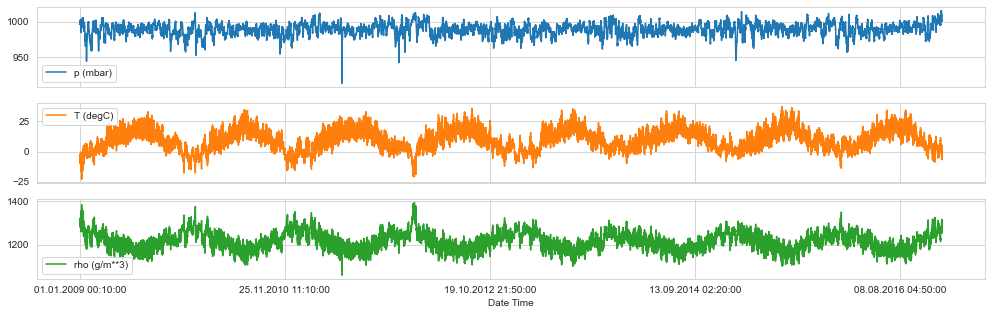

In [26]:
features.plot(subplots=True)

# Separacion(Entrenamiento-Validación-Prueba) y Normalización.

In [27]:
column_indices = {name: i for i, name in enumerate(features.columns)}

n = len(features)
train_df = features[0:int(n*0.7)]
val_df = features[int(n*0.7):int(n*0.9)]
test_df = features[int(n*0.9):]

num_features = features.shape[1]

In [28]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [29]:
train_df

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,0.947798,-1.979098,2.215821
01.01.2009 00:20:00,0.953824,-2.024163,2.265873
01.01.2009 00:30:00,0.949003,-2.035718,2.276616
01.01.2009 00:40:00,0.946592,-2.012608,2.250980
01.01.2009 00:50:00,0.946592,-2.007986,2.246341
...,...,...,...
05.08.2014 01:40:00,0.183649,0.631182,-0.619604
05.08.2014 01:50:00,0.211370,0.626560,-0.609838
05.08.2014 02:00:00,0.224628,0.609228,-0.590061


In [30]:
df_std = (features - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
df_std

,Column,Normalized
0,p (mbar),0.947798
1,p (mbar),0.953824
2,p (mbar),0.949003
3,p (mbar),0.946592
4,p (mbar),0.946592
...,...,...
1261648,rho (g/m**3),1.855197
1261649,rho (g/m**3),1.768764
1261650,rho (g/m**3),1.743128
1261651,rho (g/m**3),1.869358


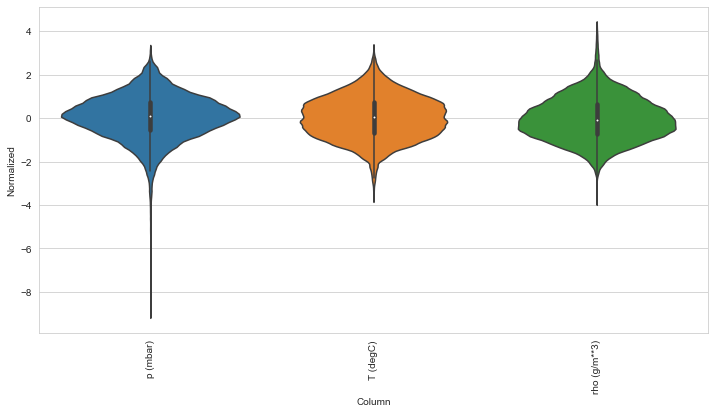

In [31]:

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(features.keys(), rotation=90)

### Modelos de salida única

Todos estos modelos se pueden convertir para predecir múltiples salidas simplemente cambiando la cantidad de unidades en la capa de salida y ajustando las ventanas de entrenamiento para incluir todas las funciones en las labels ( example_labels ):

La función windowGenerator, permite implementar la ventana de datos que pueda utilizarse para hacer la predicción según se requiera. Según la tarea y el tipo de modelo, es posible generar una variedad de ventana de datos. Aquí presentamos unos ejemplos:

Por ejemplo, para hacer una sola predicción 4 horas en el futuro(es decir, 24 periodos ya que cada periodo es de 10 minutos), con 4 horas(24 periodos de historial), se puede definir la siguiente ventana:


<img src="24241.png">

Para hacer una sola predicción 10 minutos en el futuro(es decir, 1 periodos ya que cada periodo es de 10 minutos), con 1 hora(6 periodos de historial), se puede definir la siguiente ventana:

<img src="611.png">

El resto de esta sección define una clase WindowGenerator. Esta clase puede:

* Manejar los índices y las compensaciones como se muestra en los diagramas anteriores.
* Dividir ventanas de características en pares (características, etiquetas).
* Trazar el contenido de las ventanas resultantes.
* Generar eficientemente lotes de estas ventanas a partir de los datos de entrenamiento, evaluación y prueba, usando tf.data.Datasets.

Vale la pena decir que acá se incluye la lógica necesaria para el aprendizaje supervisado, es decir, las entradas y las etiquetas(respuestas u objetivos), de todos los cojuntos, entrenamineto validación y prueba. Despues de deben crear objeto del tipo tensorflow.

In [32]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

# Split

Dada una lista de entradas consecutivas, el método split_window las convertirá en una ventana de entradas y una ventana de etiquetas.

In [33]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

# Transforma nuestros objetos a tipo tensorflow

In [34]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=64,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [35]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Definir las gráficas para visulaizar lo que se desea predecir en términos de las entradas

Note que puede cambiar el nombre de la variable que va a visualiza usando el argumento  plot_col

In [36]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=2):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [37]:
# Configuración para el ajuste de los modelos

In [40]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Ejemplos de configuración

Note que la función WindowGenerator tiene de entrada por defecto a :

self.train_df = train_df

self.val_df = val_df

self.test_df = test_df

es decir, en este caso los dataframe deben tener estos nombres(train_df:entrenamiento),(val_df:validación) y (test_df:Prueba) 

## Predicción un paso adelante

## Ejemplo 1
Vamos a suponer que queremos predecir una variable con base en las condiciones actuales, es decir basados en el primer retardo de todas las variables, que en este ejemplo son tres. Note que el tamaño del lote se definió en 64 con anterioridad.

In [42]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])# La variable a predecir es T (degC)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [43]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Forma(dimensión) de las entradas (batch, time, features): {example_inputs.shape}')
  print(f'Forma(dimensión) de las etiquetas, salidas o respuestas (batch, time, features): {example_labels.shape}')

2022-09-30 10:16:15.160345: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Forma(dimensión) de las entradas (batch, time, features): (64, 1, 3)
Forma(dimensión) de las etiquetas, salidas o respuestas (batch, time, features): (64, 1, 1)


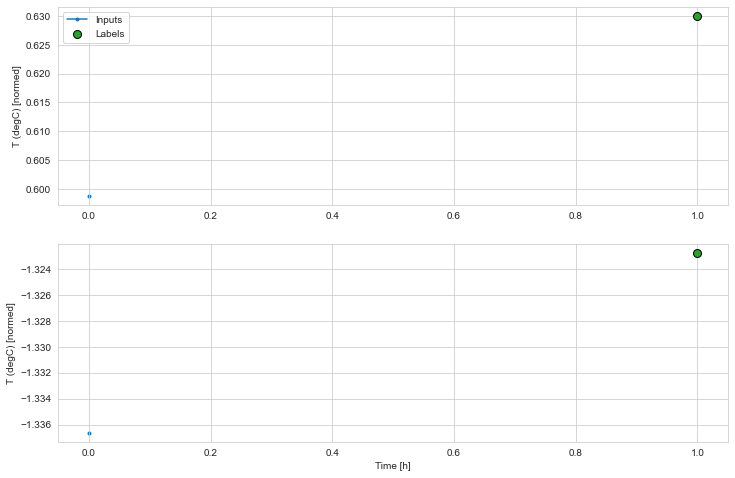

In [44]:
single_step_window.plot()

## Ejemplo de los datos que conforman los dos primeros lotes para los datos de entrenamiento

In [45]:
i=1
for batch in single_step_window.train.take(2):
    inputs, targets = batch
    print("Covariable o input",i,inputs)
    print("Respuesta o etiqueta",i,targets)
    i=i+1

Covariable o input 1 tf.Tensor(
[[[-0.8179408   0.46594533 -0.6625765 ]]

 [[-0.43466103 -0.96918905  0.8187396 ]]

 [[-0.72633934 -0.7265335   0.5067037 ]]

 [[ 0.1318216   1.1580914  -1.1206199 ]]

 [[-0.04535488  0.3769716  -0.40108162]]

 [[ 1.5227172  -2.1593568   2.5703404 ]]

 [[-1.3265699  -0.02629884 -0.32661295]]

 [[ 0.0848156   1.4712327  -1.3283997 ]]

 [[-2.4354296  -0.87905985  0.20736404]]

 [[ 0.44157913  0.09965096  0.00739735]]

 [[-1.7050285   0.06151937 -0.5226731 ]]

 [[-0.31895393  1.2875078  -1.2507569 ]]

 [[ 1.1563115   0.00605524  0.24813868]]

 [[-0.37439692  1.0876058  -1.1562672 ]]

 [[-0.09356617 -1.5677395   1.5243608 ]]

 [[ 0.04142544 -0.5636076   0.524039  ]]

 [[-0.06102355  0.12160552 -0.13568015]]

 [[ 0.2065491  -1.2488207   1.2526112 ]]

 [[ 0.11253709  1.7670413  -1.6091832 ]]

 [[-0.04656016  0.43359125 -0.46480727]]

 [[ 0.26319736  0.68317986 -0.6330332 ]]

 [[-1.6375327  -1.382859    0.91322935]]

 [[-0.41296595 -1.1794906   1.0209037 ]]

 [

# Ejemplo 2

Configuración basados en las entradas para las últimas 4 horas(24 periodos) y una sola predicción 24 pasos adelante(4 horas) sin predecir las anteriores para la variable temperatura.

In [46]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [47]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Forma(dimensión) de las entradas (batch, time, features): {example_inputs.shape}')
  print(f'Forma(dimensión) de las etiquetas, salidas o respuestas (batch, time, features): {example_labels.shape}')

Forma(dimensión) de las entradas (batch, time, features): (64, 24, 3)
Forma(dimensión) de las etiquetas, salidas o respuestas (batch, time, features): (64, 1, 1)


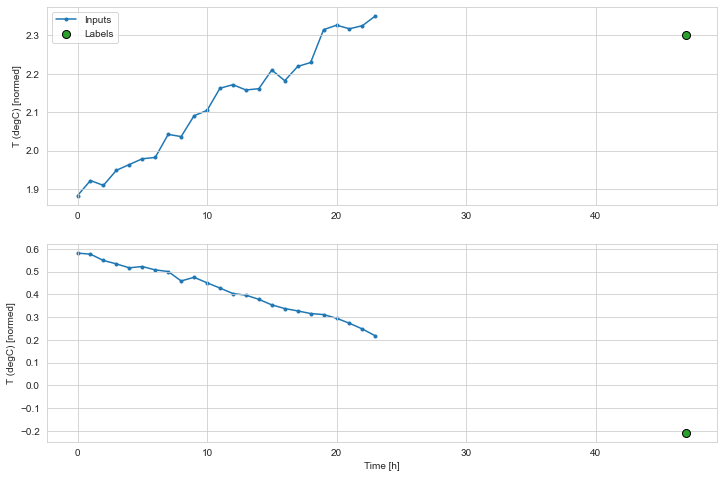

In [48]:
w1.plot()

# Ejemplo de datos de los primeros lotes en el conjunto de validación.

In [49]:
i=1
for batch in w1.val.take(2):
    inputs, targets = batch
    print("Covariable o input",i,inputs)
    print("Respuesta o etiqueta",i,targets)
    i=i+1

Covariable o input 1 tf.Tensor(
[[[ 0.6525035  -0.953012    1.0738863 ]
  [ 0.66335106 -0.953012    1.0770605 ]
  [ 0.6645563  -0.95532304  1.0804787 ]
  ...
  [ 0.6512982  -0.5566746   0.700078  ]
  [ 0.6404507  -0.5659186   0.7056937 ]
  [ 0.63562953 -0.5682296   0.70764697]]

 [[ 1.7312311  -0.80741864  1.197187  ]
  [ 1.7300258  -0.8108852   1.198896  ]
  [ 1.7300258  -0.78893065  1.1766775 ]
  ...
  [ 1.7420787  -1.1794906   1.5810058 ]
  [ 1.756542   -1.16678     1.5717276 ]
  [ 1.7625685  -1.14367     1.5490209 ]]

 [[-0.06343412  0.01761027 -0.06389725]
  [-0.06222883  0.01761027 -0.06365309]
  [-0.05981827  0.02454328 -0.06975708]
  ...
  [ 0.03419374  0.09849546 -0.11102004]
  [ 0.043836    0.115828   -0.12469298]
  [ 0.04624657  0.12045001 -0.12811121]]

 ...

 [[-0.3213645   0.57109606 -0.6540309 ]
  [-0.29725885  0.538742   -0.6213135 ]
  [-0.29123244  0.50754344 -0.594456  ]
  ...
  [-0.10682427  0.31226346 -0.3625044 ]
  [-0.08271863  0.29724193 -0.3424833 ]
  [-0.088745

# Ejemplo 3

Configuración basados en la última hora(6 retardos) para la entrada y una única predicción un paso adelante para la temperatura.

<img src="EjemploDividir.png">

In [50]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [51]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Forma(dimensión) de las entradas (batch, time, features): {example_inputs.shape}')
  print(f'Forma(dimensión) de las etiquetas, salidas o respuestas (batch, time, features): {example_labels.shape}')

Forma(dimensión) de las entradas (batch, time, features): (64, 6, 3)
Forma(dimensión) de las etiquetas, salidas o respuestas (batch, time, features): (64, 1, 1)


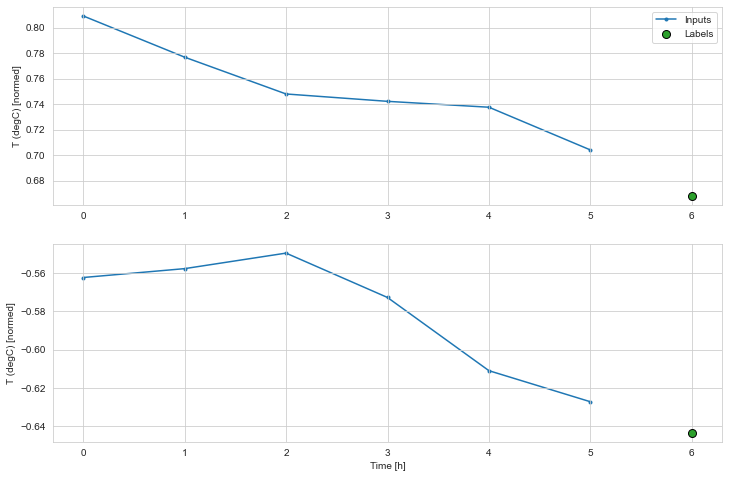

In [52]:
w2.plot()

# Ejemplo de 2 lotes del conjunto de prueba

In [53]:
i=1
for batch in w1.test.take(2):
    inputs, targets = batch
    print("Covariable o input",i,inputs)
    print("Respuesta o etiqueta",i,targets)
    i=i+1

Covariable o input 1 tf.Tensor(
[[[ 2.0096512  -1.8866582   2.400161  ]
  [ 2.013267   -1.8577707   2.3701296 ]
  [ 2.0108566  -1.8670146   2.3794076 ]
  ...
  [ 1.9120234  -1.8693256   2.357189  ]
  [ 1.9204603  -1.8878137   2.3784308 ]
  [ 1.8999707  -1.8670146   2.3505967 ]]

 [[-0.36354938  0.8946368  -1.0080622 ]
  [-0.35993353  0.90041435 -1.0129455 ]
  [-0.34667543  0.90503633 -1.0134338 ]
  ...
  [-0.3093117   1.3059958  -1.3525715 ]
  [-0.3213645   1.3510604  -1.3974968 ]
  [-0.32618564  1.363771   -1.4075073 ]]

 [[ 0.6464771   0.87499326 -0.62009275]
  [ 0.6308084   0.87383777 -0.6247318 ]
  [ 0.6151398   0.8784598  -0.63523066]
  ...
  [ 0.5114855   0.47287834 -0.3039061 ]
  [ 0.5151013   0.44514626 -0.27851352]
  [ 0.5102802   0.3758161  -0.21991521]]

 ...

 [[-0.61786395  2.030496   -1.9993502 ]
  [-0.62389034  2.0316515  -2.0013034 ]
  [-0.6275062   2.0432065  -2.0108256 ]
  ...
  [-0.65281713  1.4446561  -1.5352027 ]
  [-0.6588435   1.4319456  -1.5273896 ]
  [-0.658843

# Predicción múltiples pasos adelante

En una predicción de varios pasos adelante, el modelo necesita aprender a predecir un rango de valores futuros. Por lo tanto, a diferencia de un modelo de un solo paso, donde solo se predice un único punto futuro, un modelo de varios pasos predice una secuencia de valores futuros.

Hay dos enfoques aproximados para esto:

* Predicciones de disparo único donde se predice una secuencia de la serie temporal completa a la vez.
* Predicciones autorregresivas donde el modelo solo hace predicciones de un solo paso y su salida se retroalimenta como su entrada.

# Ejemplo 1
Aquí, los modelos aprenderán a predecir 24 horas en el futuro, dadas las 24 horas del pasado de la variable temperatura

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['T (degC)']

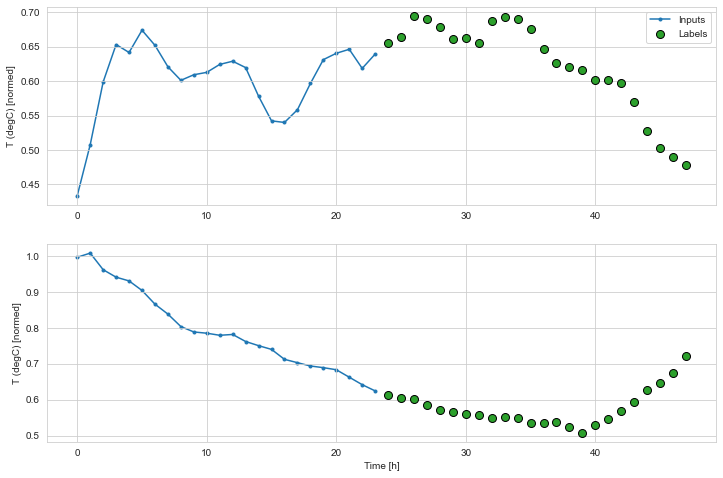

In [54]:
OUT_STEPS = 24   # Número de pasos adelante
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                     label_columns=['T (degC)'])

multi_window.plot()
multi_window


In [55]:
for example_inputs, example_labels in multi_window.train.take(1):
  print(f'Forma(dimensión) de las entradas (batch, time, features): {example_inputs.shape}')
  print(f'Forma(dimensión) de las etiquetas, salidas o respuestas (batch, time, features): {example_labels.shape}')

Forma(dimensión) de las entradas (batch, time, features): (64, 24, 3)
Forma(dimensión) de las etiquetas, salidas o respuestas (batch, time, features): (64, 24, 1)


# Ejemplo de dos lotes para el conjunto de prueba

In [56]:
i=1
for batch in multi_window.train.take(2):
    inputs, targets = batch
    print("Covariable o input",i,inputs)
    print("Respuesta o etiqueta",i,targets)
    i=i+1

Covariable o input 1 tf.Tensor(
[[[-0.07428166 -0.9899881   0.9269023 ]
  [-0.06584468 -0.9865216   0.9256815 ]
  [-0.0646394  -0.97265553  0.9122527 ]
  ...
  [-0.13575105 -0.3440621   0.28769252]
  [-0.13334048 -0.22157879  0.17367001]
  [-0.13334048 -0.14647111  0.10335205]]

 [[-1.0360968   1.4227016  -1.5142051 ]
  [-1.0397127   1.379948   -1.4785578 ]
  [-1.0469444   1.382259   -1.478802  ]
  ...
  [-1.0891293   1.0945388  -1.2568609 ]
  [-1.087924    1.0737398  -1.2380606 ]
  [-1.0975662   1.0540962  -1.2231668 ]]

 [[-1.7580609   0.11120599 -0.54220587]
  [-1.7508292   0.09965096 -0.530242  ]
  [-1.7508292   0.09156244 -0.52340555]
  ...
  [-1.5145938  -0.2262008  -0.18182632]
  [-1.4772302  -0.24699986 -0.15325965]
  [-1.442277   -0.25624388 -0.13616848]]

 ...

 [[ 0.5126908   0.48674437 -0.37715396]
  [ 0.51871717  0.4578568  -0.3498081 ]
  [ 0.52956474  0.44283527 -0.33369356]
  ...
  [ 0.5753654   0.11351699 -0.01677445]
  [ 0.57657075  0.10773948 -0.01189126]
  [ 0.560902

# Ejemplo 2
Igual al ejemplo de arriba pero se desean predecir todas las variables y no solo la temperatura

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

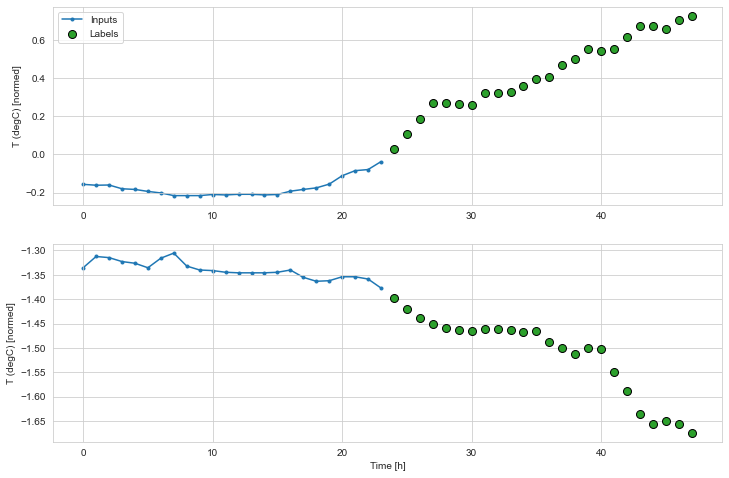

In [57]:
OUT_STEPS = 24   # Número de pasos adelante
multi_window1 = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window1.plot()
multi_window1
## Note que el nombre del eje Y está mal.

In [58]:
for example_inputs, example_labels in multi_window1.train.take(1):
  print(f'Forma(dimensión) de las entradas (batch, time, features): {example_inputs.shape}')
  print(f'Forma(dimensión) de las etiquetas, salidas o respuestas (batch, time, features): {example_labels.shape}')

Forma(dimensión) de las entradas (batch, time, features): (64, 24, 3)
Forma(dimensión) de las etiquetas, salidas o respuestas (batch, time, features): (64, 24, 3)


# Ejemplo de dos lotes para el conjunto de prueba

In [59]:
i=1
for batch in multi_window1.train.take(2):
    inputs, targets = batch
    print("Covariable o input",i,inputs)
    print("Respuesta o etiqueta",i,targets)
    i=i+1

Covariable o input 1 tf.Tensor(
[[[-0.26592153  1.3106178  -1.2541752 ]
  [-0.2671268   1.2759527  -1.224876  ]
  [-0.26592153  1.2355101  -1.1894728 ]
  ...
  [-0.18155177  0.6277157  -0.6547634 ]
  [-0.17673065  0.6277157  -0.6523218 ]
  [-0.17793593  0.60691667 -0.63400984]]

 [[-0.71790236  0.7975746  -0.9692409 ]
  [-0.7082601   0.79988563 -0.96777594]
  [-0.6889756   0.7906416  -0.95483553]
  ...
  [-0.5045674   0.46941182 -0.62985915]
  [-0.5009515   0.46825632 -0.62888247]
  [-0.5045674   0.47056735 -0.63230073]]

 [[-1.3205434  -1.0015432   0.61437804]
  [-1.2964379  -1.0084761   0.6278068 ]
  [-1.2892061  -1.0130981   0.634155  ]
  ...
  [-0.95534295 -1.0165646   0.72522646]
  [-0.93967426 -1.0015432   0.71448344]
  [-0.9360584  -1.0096316   0.72180825]]

 ...

 [[-2.0208125  -1.9317228   1.3776208 ]
  [-2.0629973  -1.9190123   1.3532048 ]
  [-2.0979505  -1.9074572   1.3317188 ]
  ...
  [-1.9653695  -1.5504069   1.0023476 ]
  [-1.9569324  -1.5746725   1.0287168 ]
  [-1.956932

In [60]:
np.array(test_df[42050:42050+w2.total_window_size-1])
###Este se puede usar para hacer una predición final

array([[ 1.38049397, -1.50649781,  1.84127985],
       [ 1.37567284, -1.52036384,  1.85519695],
       [ 1.35879889, -1.43947865,  1.76876446],
       [ 1.34554078, -1.4175241 ,  1.74312771],
       [ 1.3443355 , -1.54116289,  1.8693582 ],
       [ 1.34554078, -1.60933755,  1.9382112 ]])

## Las otras columnas

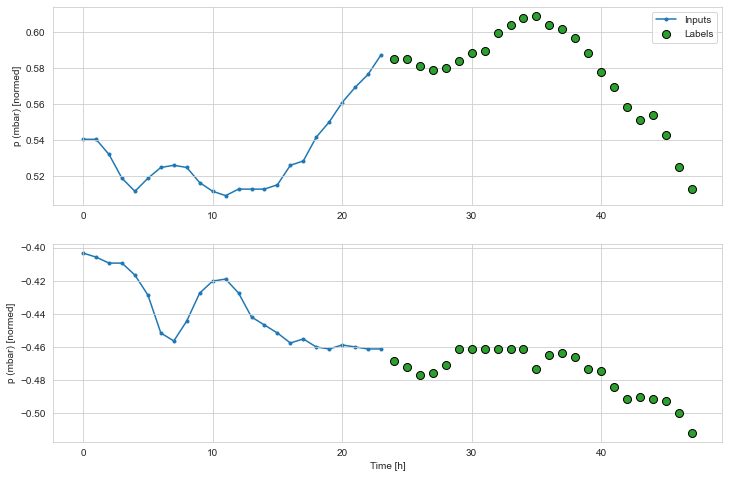

In [61]:
multi_window1.plot(plot_col='p (mbar)')

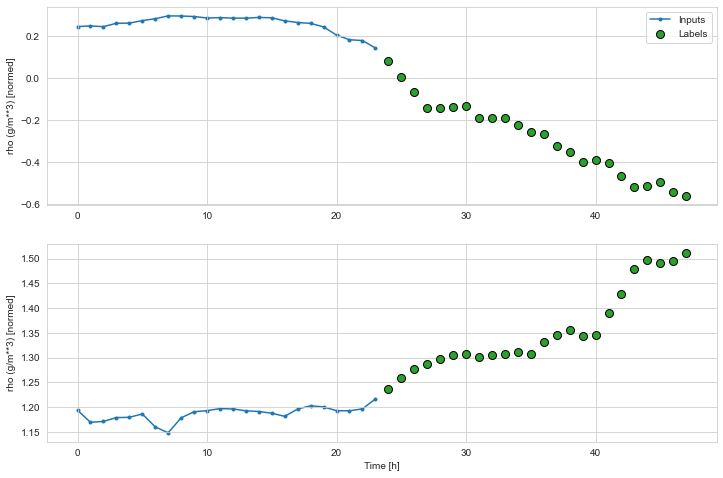

In [62]:
multi_window1.plot(plot_col='rho (g/m**3)')

## Crear objeto tensorflow

El método make_dataset tomará un data frame de serie temporal y lo convertirá en un tf.data.Dataset de (input_window, label_window) usando la función tf.keras.utils.timeseries_dataset_from_array. el objeto WindowGenerator contiene datos de entrenamiento, validación y prueba.

In [63]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [65]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (64, 6, 3)
Labels shape (batch, time, features): (64, 1, 1)


Se itera sobre el conjunto Dataset para producir lotes concretos

# Fase de Modelamiento para la predicción de un solo paso

El modelo mas simple se puede crear a partir de este tipo de datos, y es que le predice el valor de una sola característica: 1 paso de tiempo(10 minutos) hacia el futuro basandose únicamente en las condiciones actuales, es decir, basados en la información inmediantamente anterior. Es decir, la mejor predicción un paso adelante es la última información disponible, es el modelo Naive.


El modelo base, es un modelo simple, es decir, la predicción un paso adelante de la temperatura actual es la actual temperatura, ya que la temperatura no cambia drámaticamente en un periodod e 10 minutos.

### Modelo Base

In [66]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

El modelo base es entrenado con el conjunto de datos single_step_window.

In [67]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

1315/1315 [==============================] - 5s 3ms/step - loss: 7.7077e-04 - mean_absolute_error: 0.0180


## Evaluación del modelo base en una ventana grande.

Esto permite evaluar mas detalladamente la evolución del comportamineto del modelo.

In [68]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,label_columns=['T (degC)'])


wide_window



Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [69]:
for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (64, 24, 3)
Labels shape (batch, time, features): (64, 24, 1)


In [70]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (64, 24, 3)
Output shape: (64, 24, 1)


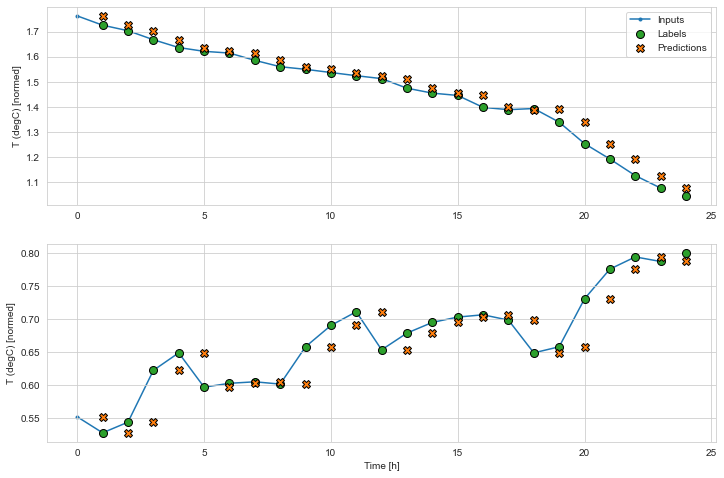

In [71]:
wide_window.plot(baseline)

In [72]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

1314/1314 [==============================] - 5s 4ms/step - loss: 7.7096e-04 - mean_absolute_error: 0.0180


## Denso(MLP)

Ajustaremos una red perceptrón multicapa con dos capas ocultas y usando función  de activación RELU.

In [102]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [104]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

AttributeError: 'MapDataset' object has no attribute 'train'

In [89]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

<AxesSubplot:>

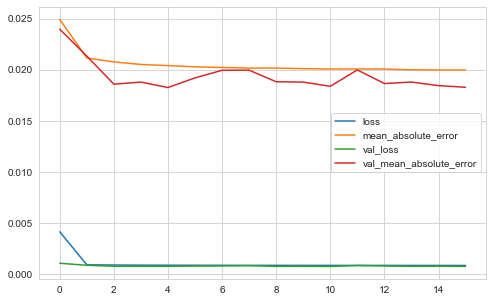

In [75]:
pd.DataFrame(history.history).plot(figsize=(8,5))

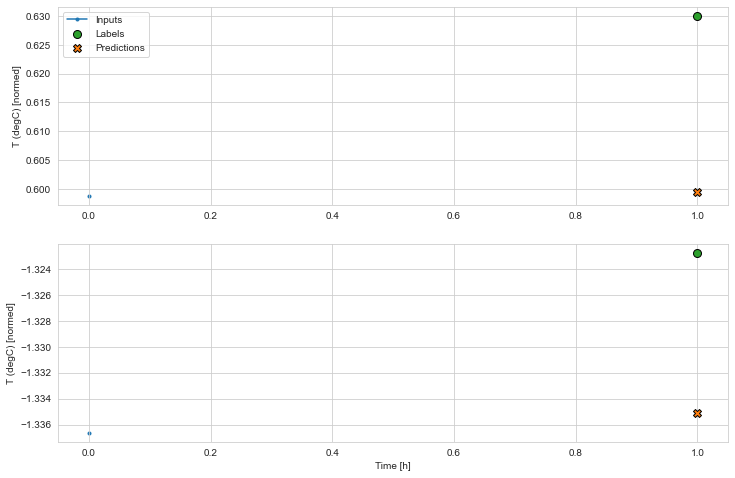

In [76]:
single_step_window.plot(dense)

## Predicción

In [77]:
test_df.shape

(42056, 3)

In [78]:
print(test_df.shape)
print(test_df.tail(10))

input_predict=tf.constant(np.array(test_df.iloc[42055]),dtype=tf.float32, shape=(1,1,3))
print(input_predict)


(42056, 3)
                     p (mbar)  T (degC)  rho (g/m**3)
Date Time                                            
31.12.2016 22:30:00  1.420268 -1.523830      1.869114
31.12.2016 22:40:00  1.421474 -1.566584      1.910377
31.12.2016 22:50:00  1.405805 -1.524986      1.864719
31.12.2016 23:00:00  1.392547 -1.486854      1.824189
31.12.2016 23:10:00  1.380494 -1.506498      1.841280
31.12.2016 23:20:00  1.375673 -1.520364      1.855197
31.12.2016 23:30:00  1.358799 -1.439479      1.768764
31.12.2016 23:40:00  1.345541 -1.417524      1.743128
31.12.2016 23:50:00  1.344335 -1.541163      1.869358
01.01.2017 00:00:00  1.345541 -1.609338      1.938211
tf.Tensor([[[ 1.3455408 -1.6093376  1.9382112]]], shape=(1, 1, 3), dtype=float32)


In [79]:
dense.predict(input_predict)

array([[[-1.6088382]]], dtype=float32)

# Denso(mlp) con varios retardos incluídos a través de una convolución

 <img src="DensoUnpasoadel1carac.png">

Aquí el modelo tomará múltiples pasos(retardos) de tiempo como entrada para producir una única salida.

Crear un WindowGenerator que produzca lotes de entradas de tres periodos(30 minutos) y etiquetas de 10 minutos:

Tenga en cuenta que el parámetro de shift de la Window es relativo al final de las dos ventanas.

In [92]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, 'Given 3 periods of inputs, predict 1 period into the future.')

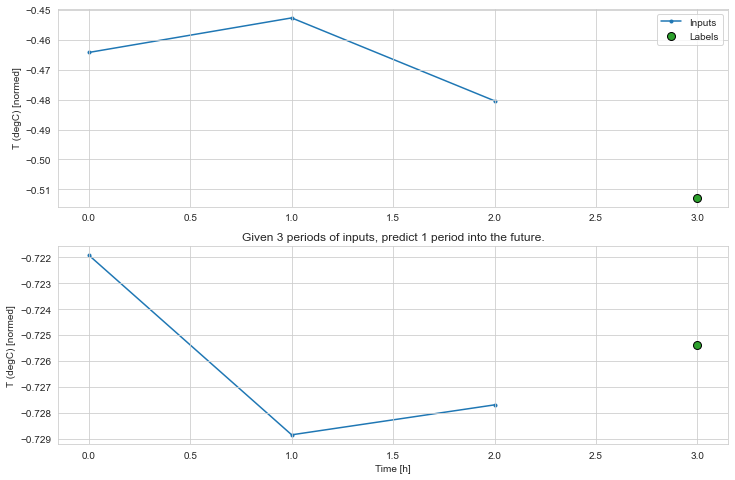

In [93]:
conv_window.plot()
plt.title("Given 3 periods of inputs, predict 1 period into the future.")

In [96]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [97]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (64, 3, 3)
Output shape: (64, 1, 1)


In [98]:
conv_window.example[0]

<tf.Tensor: shape=(64, 3, 3), dtype=float32, numpy=
array([[[ 7.51336634e-01, -4.64234352e-01,  6.10959768e-01],
        [ 7.34462678e-01, -4.52679336e-01,  5.95089436e-01],
        [ 7.21204579e-01, -4.80411410e-01,  6.19261205e-01]],

       [[ 1.12933815e-02, -7.21911490e-01,  6.77859545e-01],
        [ 2.21409220e-02, -7.28844464e-01,  6.88114226e-01],
        [ 2.81673335e-02, -7.27688968e-01,  6.87381744e-01]],

       [[ 8.99586380e-01, -1.62648156e-01,  3.48732412e-01],
        [ 9.01996911e-01, -1.43004611e-01,  3.32862049e-01],
        [ 8.93559933e-01, -8.52294713e-02,  2.78902769e-01]],

       [[ 2.46645331e+00, -1.10650532e-01,  7.34748721e-01],
        [ 2.45440030e+00, -6.44304231e-02,  6.88358366e-01],
        [ 2.43993711e+00, -5.05643934e-02,  6.72243834e-01]],

       [[ 3.12613934e-01,  1.45043361e+00, -1.29201984e+00],
        [ 3.06587517e-01,  1.41923511e+00, -1.26711559e+00],
        [ 3.02971661e-01,  1.35914886e+00, -1.21779537e+00]],

       [[-4.74435359e-0

In [99]:

history = compile_and_fit(multi_step_dense, conv_window)

#IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
4600/4600 [==============================] - 9s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0305 - val_loss: 7.8249e-04 - val_mean_absolute_error: 0.0193
Epoch 2/20
4600/4600 [==============================] - 8s 2ms/step - loss: 8.1076e-04 - mean_absolute_error: 0.0195 - val_loss: 6.6016e-04 - val_mean_absolute_error: 0.0175
Epoch 3/20
4600/4600 [==============================] - 9s 2ms/step - loss: 7.3933e-04 - mean_absolute_error: 0.0185 - val_loss: 7.3893e-04 - val_mean_absolute_error: 0.0184
Epoch 4/20
4600/4600 [==============================] - 8s 2ms/step - loss: 6.9091e-04 - mean_absolute_error: 0.0178 - val_loss: 5.5753e-04 - val_mean_absolute_error: 0.0151
Epoch 5/20
4600/4600 [==============================] - 8s 2ms/step - loss: 6.7375e-04 - mean_absolute_error: 0.0175 - val_loss: 5.8318e-04 - val_mean_absolute_error: 0.0158
Epoch 6/20
1315/1315 [==============================] - 2s 1ms/step - loss: 6.2332e-04 - mean_absolute_error: 0.0165


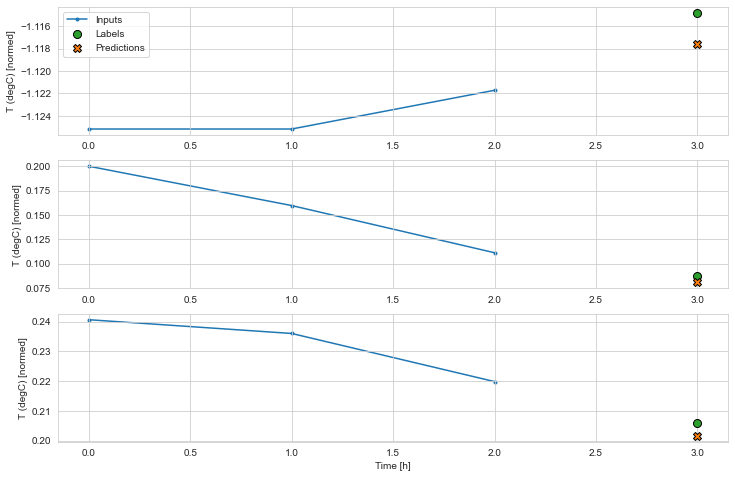

In [63]:
conv_window.plot(multi_step_dense)

## Predicción

In [64]:
np.array(test_df.iloc[42052:42055])

array([[ 1.35879889, -1.43947865,  1.76876446],
       [ 1.34554078, -1.4175241 ,  1.74312771],
       [ 1.3443355 , -1.54116289,  1.8693582 ]])

In [65]:
print(test_df.shape)
print(test_df.tail(10))

input_predict=tf.constant(np.array(test_df.iloc[42053:42056]),dtype=tf.float32, shape=(1,3,3))
print(input_predict)


(42056, 3)
                     p (mbar)  T (degC)  rho (g/m**3)
Date Time                                            
31.12.2016 22:30:00  1.420268 -1.523830      1.869114
31.12.2016 22:40:00  1.421474 -1.566584      1.910377
31.12.2016 22:50:00  1.405805 -1.524986      1.864719
31.12.2016 23:00:00  1.392547 -1.486854      1.824189
31.12.2016 23:10:00  1.380494 -1.506498      1.841280
31.12.2016 23:20:00  1.375673 -1.520364      1.855197
31.12.2016 23:30:00  1.358799 -1.439479      1.768764
31.12.2016 23:40:00  1.345541 -1.417524      1.743128
31.12.2016 23:50:00  1.344335 -1.541163      1.869358
01.01.2017 00:00:00  1.345541 -1.609338      1.938211
tf.Tensor(
[[[ 1.3455408 -1.4175241  1.7431277]
  [ 1.3443356 -1.5411628  1.8693582]
  [ 1.3455408 -1.6093376  1.9382112]]], shape=(1, 3, 3), dtype=float32)


In [66]:
multi_step_dense.predict(input_predict)

1/1 [==============================] - 0s 58ms/step


array([[[-1.6128035]]], dtype=float32)

# Red(convolucional)

Una capa de convolución ( tf.keras.layers.Conv1D ) también toma varios pasos de tiempo como entrada para cada predicción.

A continuación se muestra el mismo modelo que multi_step_dense , reescrito con una convolución.

Tenga en cuenta los cambios:

El tf.keras.layers.Flatten y el primer tf.keras.layers.Dense se reemplazan por un tf.keras.layers.Conv1D .
El tf.keras.layers.Reshape ya no es necesario ya que la convolución mantiene el eje del tiempo en su salida.

In [63]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

Ejecútelo en un lote de ejemplo para verificar que el modelo produce resultados con la forma esperada:

In [64]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (64, 3, 3)
Output shape: (64, 1, 1)


In [65]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

1315/1315 [==============================] - 2s 1ms/step - loss: 5.7717e-04 - mean_absolute_error: 0.0159


La diferencia entre este conv_model y el modelo multi_step_dense es que el modelo conv_model se puede ejecutar en entradas de cualquier longitud. La capa convolucional se aplica a una ventana deslizante de entradas:
    
 <img src="Convo1carac.png">

In [66]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (64, 24, 3)
Labels shape: (64, 24, 1)
Output shape: (64, 22, 1)


Tenga en cuenta que la salida es más corta que la entrada. Para que el entrenamiento o el trazado funcionen, necesita que las etiquetas y la predicción tengan la misma longitud. Por lo tanto, construya un WindowGenerator para producir ventanas anchas con algunos pasos de tiempo de entrada adicionales para que la etiqueta y la longitud de la predicción coincidan:

In [67]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [68]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (64, 26, 3)
Labels shape: (64, 24, 1)
Output shape: (64, 24, 1)


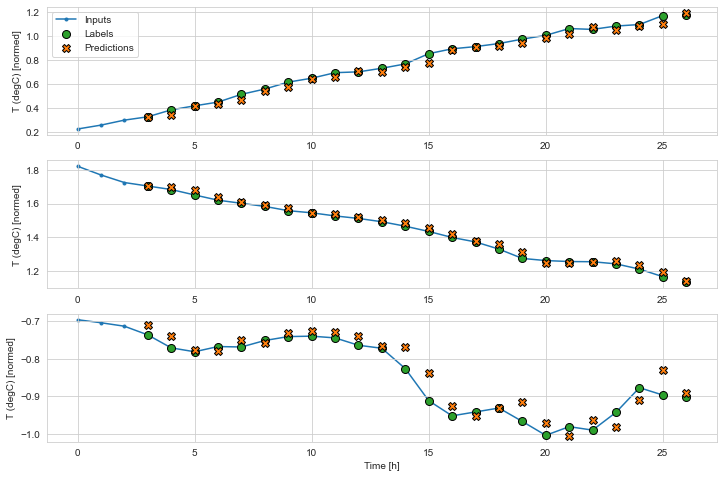

In [69]:
wide_conv_window.plot(conv_model)

## Predicción

In [70]:
np.array(test_df.iloc[(42056-24):42056]).shape

(24, 3)

In [74]:
print(test_df.shape)
print(test_df.tail(10))

input_predict_conv=tf.constant(np.array(test_df.iloc[(42056-24):42056]),dtype=tf.float32, shape=(1,24,3))
print(input_predict_conv)

(42056, 3)
                     p (mbar)  T (degC)  rho (g/m**3)
Date Time                                            
31.12.2016 22:30:00  1.420268 -1.523830      1.869114
31.12.2016 22:40:00  1.421474 -1.566584      1.910377
31.12.2016 22:50:00  1.405805 -1.524986      1.864719
31.12.2016 23:00:00  1.392547 -1.486854      1.824189
31.12.2016 23:10:00  1.380494 -1.506498      1.841280
31.12.2016 23:20:00  1.375673 -1.520364      1.855197
31.12.2016 23:30:00  1.358799 -1.439479      1.768764
31.12.2016 23:40:00  1.345541 -1.417524      1.743128
31.12.2016 23:50:00  1.344335 -1.541163      1.869358
01.01.2017 00:00:00  1.345541 -1.609338      1.938211
tf.Tensor(
[[[ 1.5359753 -1.2141557  1.5839356]
  [ 1.538386  -1.3008183  1.6725656]
  [ 1.5420017 -1.4209906  1.794157 ]
  [ 1.5347701 -1.4337012  1.8046559]
  [ 1.5275384 -1.4521892  1.8227237]
  [ 1.5227172 -1.4094356  1.7770659]
  [ 1.5106645 -1.3701485  1.7340938]
  [ 1.4937905 -1.3539715  1.7140727]
  [ 1.4925852 -1.3424164  1.701864

In [72]:
conv_model.predict(input_predict_conv)

array([[[-1.4209603],
        [-1.4205841],
        [-1.4434181],
        [-1.3758243],
        [-1.3312417],
        [-1.3274292],
        [-1.3228152],
        [-1.322904 ],
        [-1.3226461],
        [-1.3419473],
        [-1.3839531],
        [-1.421639 ],
        [-1.5299895],
        [-1.5596151],
        [-1.4926677],
        [-1.4500526],
        [-1.495762 ],
        [-1.5105146],
        [-1.3864908],
        [-1.3848268],
        [-1.5565377],
        [-1.6005627]]], dtype=float32)

## RNN(LSTM)

In [69]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [70]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (64, 24, 3)
Output shape: (64, 24, 1)


In [71]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

1314/1314 [==============================] - 7s 5ms/step - loss: 5.2410e-04 - mean_absolute_error: 0.0144


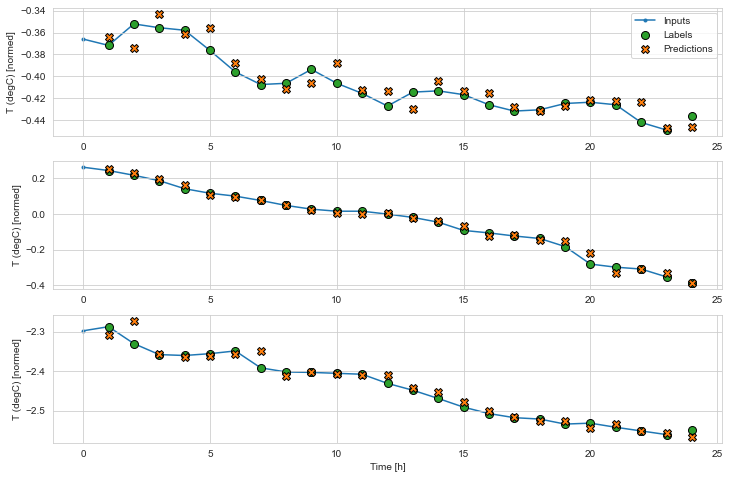

In [72]:
wide_window.plot(lstm_model)

# Predicción

In [75]:
lstm_model.predict(input_predict_conv)

1/1 [==============================] - 0s 339ms/step


array([[[-1.2197614],
        [-1.3326013],
        [-1.4766889],
        [-1.4318619],
        [-1.4773022],
        [-1.3907435],
        [-1.3631523],
        [-1.3494842],
        [-1.336277 ],
        [-1.33495  ],
        [-1.3330743],
        [-1.3533993],
        [-1.3972354],
        [-1.4361944],
        [-1.5660658],
        [-1.5770168],
        [-1.5118706],
        [-1.4850786],
        [-1.5252999],
        [-1.5281107],
        [-1.4037737],
        [-1.4215416],
        [-1.5979102],
        [-1.623096 ]]], dtype=float32)

## Rendimiento

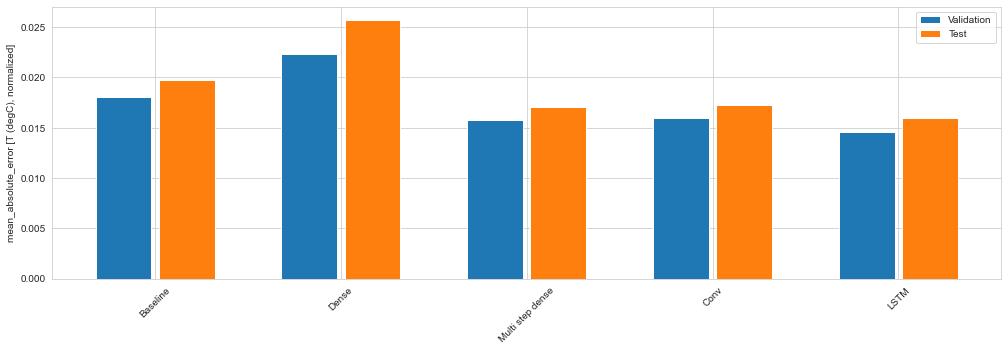

In [78]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


# Predicción Multivariada( Mútiples Salidas)

Los modelos anteriores se pueden usar para predecir mas de una sola salida, en vez de predecir únicamente la temperatura(T (degC)),  procederemos a predecir 'p (mbar)', 'T (degC)', 'rho (g/m**3)' al mismo tiempo, la presión del aire, temperatura y la densidad del aire. Se debe cambiar las unidades de la capa de salida y ajustando la ventana de entrenamineto para incluir las funciones en las labels. Note que ahora la salida es 3. En este caso es como si se deseara predecir la observación siguiente con base en la última información disponible o con base en los últimos 24 periodos.

In [20]:
# Esta configuración consiste en que solo la última información 
#es usada para predecir el siguiente paso adelante. Note que batch es 64. En este caso 
##como no se especifica  Ninguna variable, entonces se toman todas como respuesta

single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)


# Esta configuración consiste en que los últimos 24 periodos de información 
#es usada para predecir el siguiente paso adelante. Note que batch es 32.
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

2022-06-07 16:13:46.432091: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Inputs shape (batch, time, features): (64, 24, 3)
Labels shape (batch, time, features): (64, 24, 3)


In [21]:
single_step_window.example[0] 

<tf.Tensor: shape=(64, 1, 3), dtype=float32, numpy=
array([[[-1.82435143e+00, -7.51954556e-01,  2.62788266e-01]],

       [[ 1.89635479e+00, -4.15703237e-01,  8.68303955e-01]],

       [[ 4.39168572e-01,  8.43794703e-01, -7.66344309e-01]],

       [[ 8.70659590e-01, -1.42330158e+00,  1.61323488e+00]],

       [[-1.45071387e+00, -5.26631534e-01,  1.31674558e-01]],

       [[ 5.64517915e-01,  2.09423721e-01, -9.07547995e-02]],

       [[ 8.14011335e-01,  4.89973836e-03,  1.63903624e-01]],

       [[-7.31160462e-01, -1.14944744e+00,  9.35203671e-01]],

       [[ 6.62145793e-01,  1.03098619e+00, -7.54380524e-01]],

       [[ 7.50131369e-01,  4.59012300e-01, -2.89500684e-01]],

       [[ 4.70505893e-01,  1.04369664e+00, -8.54485929e-01]],

       [[ 6.41655982e-01,  1.33834982e+00, -1.01807284e+00]],

       [[ 2.35475868e-01, -1.62648156e-01,  1.87098786e-01]],

       [[ 1.21295977e+00, -6.16760731e-01,  8.68792295e-01]],

       [[-3.57126258e-02,  3.97770673e-01, -4.31113243e-01]],

   

In [22]:
wide_window.example[0]

<tf.Tensor: shape=(64, 24, 3), dtype=float32, numpy=
array([[[-0.32377508,  0.5907396 , -0.6891899 ],
        [-0.31051695,  0.57225156, -0.6696571 ],
        [-0.28641132,  0.5768736 , -0.6669714 ],
        ...,
        [-0.18034649,  0.86459374, -0.8735304 ],
        [-0.17311479,  0.8576607 , -0.86449647],
        [-0.16588311,  0.87499326, -0.875972  ]],

       [[ 1.9047917 , -1.0061651 ,  1.4694248 ],
        [ 1.9072022 , -1.0350527 ,  1.498724  ],
        [ 1.9072022 , -1.0697178 ,  1.5331504 ],
        ...,
        [ 1.9325132 , -1.3008183 ,  1.7719386 ],
        [ 1.9288974 , -1.3077513 ,  1.7780426 ],
        [ 1.939745  , -1.359749  ,  1.8341992 ]],

       [[-0.33341733,  1.1384479 , -1.1877637 ],
        [-0.33221206,  1.1627134 , -1.2092497 ],
        [-0.33341733,  1.1673355 , -1.2136446 ],
        ...,
        [-0.37439692,  0.7467325 , -0.8532651 ],
        [-0.37560222,  0.7132229 , -0.82421017],
        [-0.37439692,  0.69935685, -0.8110255 ]],

       ...,

       

## Modelo Base

Usaremos el modelo base anterior.

In [25]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [26]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

1314/1314 [==============================] - 5s 4ms/step - loss: 5.3296e-04 - mean_absolute_error: 0.0147


In [27]:
num_features

3

## Modelo Denso(MLP)

In [28]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [29]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

1315/1315 [==============================] - 5s 4ms/step - loss: 7.5221e-04 - mean_absolute_error: 0.0192


In [86]:
single_step_window.example[0]

<tf.Tensor: shape=(64, 1, 3), dtype=float32, numpy=
array([[[ 0.6874567 ,  0.01067725,  0.11800163]],

       [[ 0.39336783,  0.6254047 , -0.5187665 ]],

       [[ 0.6054975 ,  0.3711941 , -0.25165597]],

       [[ 0.1860593 ,  1.0448521 , -0.9958543 ]],

       [[-0.43948215, -1.545785  ,  1.3971536 ]],

       [[-0.71067065,  1.1338259 , -1.2473387 ]],

       [[ 1.19247   , -2.393924  ,  2.733439  ]],

       [[-0.7938351 ,  0.6046057 , -0.7775757 ]],

       [[ 0.26319736, -2.23562   ,  2.3093338 ]],

       [[ 0.9779297 ,  0.21751224,  0.00519991]],

       [[-0.00678585,  0.48558888, -0.4157312 ]],

       [[-1.5712421 , -0.307086  , -0.12469298]],

       [[-0.6516118 , -0.60173917,  0.3785199 ]],

       [[ 0.59465   ,  0.6924239 , -0.49923375]],

       [[-1.1771148 , -0.8212847 ,  0.48204353]],

       [[-0.7215182 , -2.2321534 ,  2.0410023 ]],

       [[ 1.3925468 ,  0.91081387, -0.4772594 ]],

       [[ 0.87186486,  0.66122526, -0.45015767]],

       [[ 1.244297  , -1.52383

# Predicción

In [30]:
print(np.array(test_df.iloc[(42055):42056]).shape)

print(test_df.shape)
print(test_df.tail(10))



print(np.array(test_df.iloc[(42055):42056]))

(1, 3)
(42056, 3)
                     p (mbar)  T (degC)  rho (g/m**3)
Date Time                                            
31.12.2016 22:30:00  1.420268 -1.523830      1.869114
31.12.2016 22:40:00  1.421474 -1.566584      1.910377
31.12.2016 22:50:00  1.405805 -1.524986      1.864719
31.12.2016 23:00:00  1.392547 -1.486854      1.824189
31.12.2016 23:10:00  1.380494 -1.506498      1.841280
31.12.2016 23:20:00  1.375673 -1.520364      1.855197
31.12.2016 23:30:00  1.358799 -1.439479      1.768764
31.12.2016 23:40:00  1.345541 -1.417524      1.743128
31.12.2016 23:50:00  1.344335 -1.541163      1.869358
01.01.2017 00:00:00  1.345541 -1.609338      1.938211
[[ 1.34554078 -1.60933755  1.9382112 ]]


In [31]:
input_predict_denso=tf.constant(np.array(test_df.iloc[(42055):42056]),dtype=tf.float32, shape=(1,1,3))
print(input_predict_denso)

tf.Tensor([[[ 1.3455408 -1.6093376  1.9382112]]], shape=(1, 1, 3), dtype=float32)


In [32]:
dense.predict(input_predict_denso)

array([[[ 1.3311157, -1.6164715,  1.9579407]]], dtype=float32)

## Red Neuronal Recurrente(LSTM)

In [33]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

1314/1314 [==============================] - 8s 6ms/step - loss: 3.9083e-04 - mean_absolute_error: 0.0128

CPU times: user 11min 8s, sys: 1min 40s, total: 12min 48s
Wall time: 6min 26s


## PRedicción

In [91]:
wide_window.example[0]

<tf.Tensor: shape=(64, 24, 3), dtype=float32, numpy=
array([[[ 1.4733007 , -0.37063864,  0.7098444 ],
        [ 1.4588373 , -0.3983707 ,  0.73133045],
        [ 1.4467845 , -0.3983707 ,  0.7281564 ],
        ...,
        [ 1.3154087 , -0.3521506 ,  0.6473396 ],
        [ 1.325051  , -0.3509951 ,  0.64856035],
        [ 1.3274616 , -0.3567726 ,  0.65393186]],

       [[ 0.3077928 , -0.23660032,  0.29062244],
        [ 0.33189845, -0.25046635,  0.3101552 ],
        [ 0.35841465, -0.2735764 ,  0.33847773],
        ...,
        [ 0.6838409 , -0.28975347,  0.44566378],
        [ 0.68504614, -0.29206446,  0.44859368],
        [ 0.69227785, -0.25971037,  0.42002702]],

       [[ 0.4174735 ,  2.009697  , -1.7263798 ],
        [ 0.41867876,  1.9415222 , -1.6707114 ],
        [ 0.42108932,  1.9172567 , -1.6511786 ],
        ...,
        [ 0.6175503 ,  1.2932853 , -1.0754503 ],
        [ 0.6259873 ,  1.2655532 , -1.0500578 ],
        [ 0.63442427,  1.2355101 , -1.0217352 ]],

       ...,

       

In [34]:
print(np.array(test_df.iloc[(42056-24):42056]).shape)

print(test_df.shape)
print(test_df.tail(24))



print(np.array(test_df.iloc[(42056-24):42056]))

(24, 3)
(42056, 3)
                     p (mbar)  T (degC)  rho (g/m**3)
Date Time                                            
31.12.2016 20:10:00  1.535975 -1.214156      1.583936
31.12.2016 20:20:00  1.538386 -1.300818      1.672566
31.12.2016 20:30:00  1.542002 -1.420991      1.794157
31.12.2016 20:40:00  1.534770 -1.433701      1.804656
31.12.2016 20:50:00  1.527538 -1.452189      1.822724
31.12.2016 21:00:00  1.522717 -1.409436      1.777066
31.12.2016 21:10:00  1.510664 -1.370148      1.734094
31.12.2016 21:20:00  1.493790 -1.353971      1.714073
31.12.2016 21:30:00  1.492585 -1.342416      1.701865
31.12.2016 21:40:00  1.487764 -1.338950      1.696982
31.12.2016 21:50:00  1.464864 -1.338950      1.690633
31.12.2016 22:00:00  1.451606 -1.351660      1.701132
31.12.2016 22:10:00  1.445579 -1.386326      1.734338
31.12.2016 22:20:00  1.428705 -1.424457      1.770229
31.12.2016 22:30:00  1.420268 -1.523830      1.869114
31.12.2016 22:40:00  1.421474 -1.566584      1.910377
31.12.201

In [35]:
input_predict_lstm=tf.constant(np.array(test_df.iloc[(42056-24):42056]),dtype=tf.float32, shape=(1,24,3))
print(input_predict_lstm)

tf.Tensor(
[[[ 1.5359753 -1.2141557  1.5839356]
  [ 1.538386  -1.3008183  1.6725656]
  [ 1.5420017 -1.4209906  1.794157 ]
  [ 1.5347701 -1.4337012  1.8046559]
  [ 1.5275384 -1.4521892  1.8227237]
  [ 1.5227172 -1.4094356  1.7770659]
  [ 1.5106645 -1.3701485  1.7340938]
  [ 1.4937905 -1.3539715  1.7140727]
  [ 1.4925852 -1.3424164  1.7018647]
  [ 1.4877641 -1.3389499  1.6969815]
  [ 1.4648638 -1.3389499  1.6906334]
  [ 1.4516056 -1.3516605  1.7011323]
  [ 1.4455792 -1.3863255  1.7343379]
  [ 1.4287052 -1.4244571  1.7702295]
  [ 1.4202683 -1.5238303  1.869114 ]
  [ 1.4214735 -1.566584   1.910377 ]
  [ 1.4058049 -1.5249859  1.8647192]
  [ 1.3925468 -1.4868543  1.8241887]
  [ 1.380494  -1.5064979  1.8412799]
  [ 1.3756728 -1.5203638  1.855197 ]
  [ 1.3587989 -1.4394786  1.7687645]
  [ 1.3455408 -1.4175241  1.7431277]
  [ 1.3443356 -1.5411628  1.8693582]
  [ 1.3455408 -1.6093376  1.9382112]]], shape=(1, 24, 3), dtype=float32)


In [36]:
lstm_model.predict(input_predict_lstm)

array([[[ 1.5647446, -1.2186459,  1.5949283],
        [ 1.5609945, -1.3440629,  1.7123711],
        [ 1.5551469, -1.479829 ,  1.8476877],
        [ 1.5380507, -1.4450586,  1.8083764],
        [ 1.529251 , -1.4842067,  1.8500943],
        [ 1.5222468, -1.3962253,  1.7634313],
        [ 1.5052505, -1.364508 ,  1.7292948],
        [ 1.4848301, -1.3490293,  1.7096119],
        [ 1.4888645, -1.3366473,  1.6973388],
        [ 1.482322 , -1.3361555,  1.6946249],
        [ 1.452426 , -1.3348078,  1.685408 ],
        [ 1.4429523, -1.3576818,  1.7054055],
        [ 1.4392751, -1.404332 ,  1.7504561],
        [ 1.4193727, -1.4459772,  1.7879286],
        [ 1.4163021, -1.5836198,  1.9254375],
        [ 1.4206834, -1.5917115,  1.9331397],
        [ 1.399755 , -1.5189502,  1.8564053],
        [ 1.3873168, -1.485672 ,  1.822588 ],
        [ 1.3742371, -1.5259277,  1.8611227],
        [ 1.371757 , -1.5298798,  1.8646698],
        [ 1.3480501, -1.3981687,  1.7272089],
        [ 1.3366176, -1.4164206,  

## Rendimiento

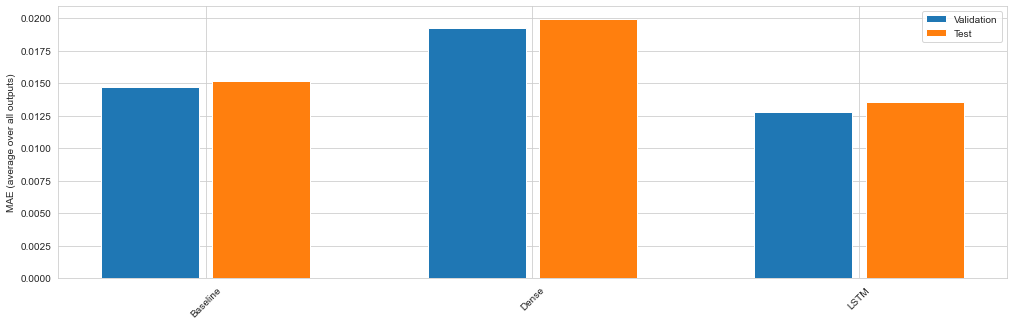

In [37]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

# Varios pasos adelante

Hay dos enfoques aproximados para esto:

1) Predicciones de disparo único donde se predice la serie temporal completa a la vez.

2) Predicciones autorregresivas donde el modelo solo hace predicciones de un solo paso y su salida se retroalimenta como su entrada.

Para el modelo de varios pasos, los datos de entrenamiento nuevamente consisten en muestras por 10 minutos. Sin embargo, aquí, los modelos aprenderán a predecir 24 periodos(4 horas) en el futuro, dadas las 24 periodos del pasado(4 horas).

Aquí hay un objeto de Window que genera estos segmentos a partir del conjunto de datos:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

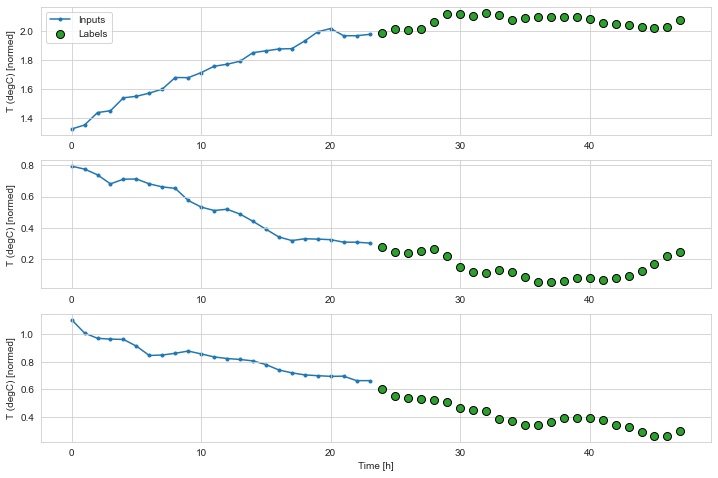

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window
## Note que el nombre del eje Y está mal.

In [40]:
multi_window.example[0]

<tf.Tensor: shape=(64, 24, 3), dtype=float32, numpy=
array([[[ 0.5910341 ,  1.3244839 , -1.1196432 ],
        [ 0.58982885,  1.3522159 , -1.1450359 ],
        [ 0.577776  ,  1.4377232 , -1.2199928 ],
        ...,
        [ 0.3620305 ,  1.9669434 , -1.6987897 ],
        [ 0.34515655,  1.9669434 , -1.7009871 ],
        [ 0.3415407 ,  1.9761873 , -1.7058704 ]],

       [[ 0.72964156,  0.7952636 , -0.5685751 ],
        [ 0.735668  ,  0.77677554, -0.5512397 ],
        [ 0.73687327,  0.73979944, -0.51974314],
        ...,
        [ 0.8429381 ,  0.30764145, -0.11712404],
        [ 0.8489645 ,  0.30764145, -0.11272916],
        [ 0.8549909 ,  0.30186394, -0.10760181]],

       [[ 0.1800329 ,  1.1060938 , -0.9819372 ],
        [ 0.17521176,  1.0090317 , -0.90136456],
        [ 0.17641704,  0.9709    , -0.8681589 ],
        ...,
        [ 0.25837624,  0.69589037, -0.6142329 ],
        [ 0.2740449 ,  0.6635363 , -0.5790739 ],
        [ 0.28127658,  0.6635363 , -0.5785856 ]],

       ...,

       

# Modelo Línea de base

Una línea de base simple para esta tarea es repetir el último paso de tiempo de entrada para el número requerido de pasos de tiempo de salida:
 <img src="LineadeBase.png">

1314/1314 [==============================] - 5s 4ms/step - loss: 0.0363 - mean_absolute_error: 0.1210


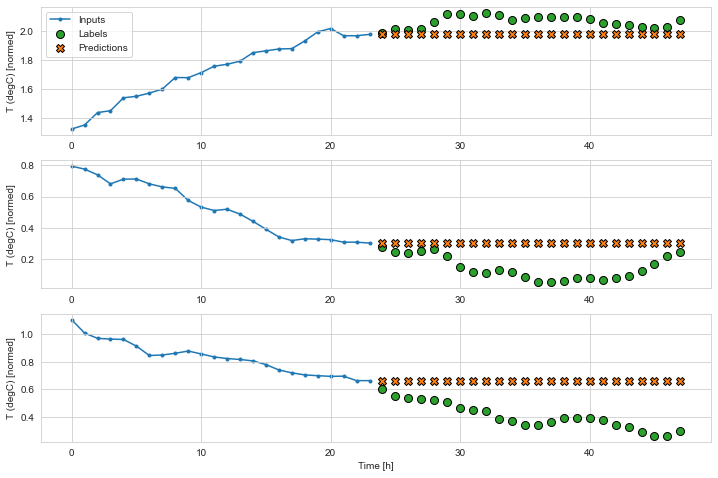

In [41]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Dado que esta tarea es predecir 24 periodos en el futuro, dadas las 24 periodos del pasado, otro enfoque simple es repetir el las 4 horas anteriores, asumiendo que lñas 4 horas siguientes será similar:

1314/1314 [==============================] - 5s 4ms/step - loss: 0.0904 - mean_absolute_error: 0.2165


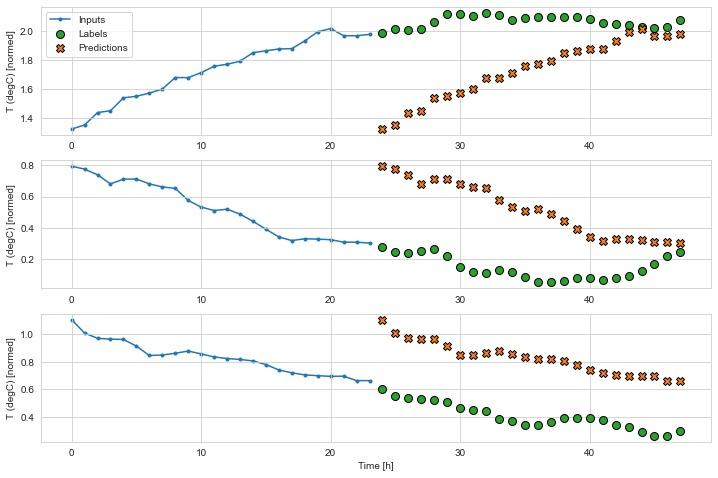

In [42]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

# Modelos de Disparo Único

Un enfoque de alto nivel para este problema es usar un modelo de "disparo único", donde el modelo realiza la predicción de secuencia completa en un solo paso. Esto se puede implementar de manera eficiente como unidades de salida tf.keras.layers.Dense con OUT_STEPS*features . El modelo solo necesita remodelar esa salida según lo requerido (OUTPUT_STEPS, features) .



# Modelo Lineal

 <img src="ModeloLineal.png">

1314/1314 [==============================] - 5s 4ms/step - loss: 0.0351 - mean_absolute_error: 0.1214


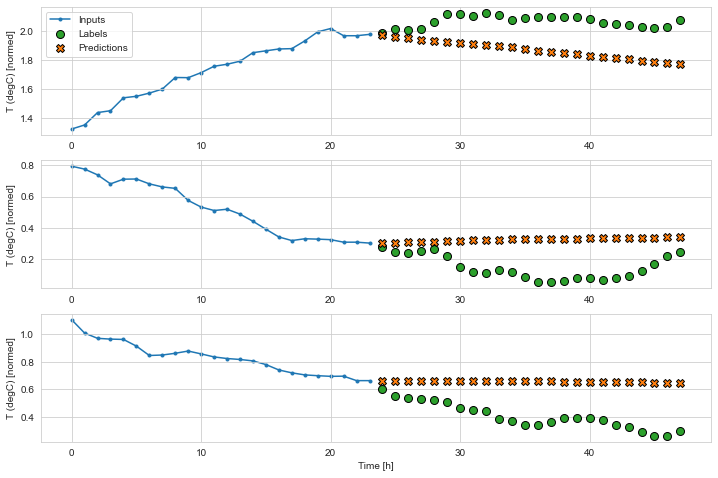

In [43]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

## Predicción

In [44]:
multi_linear_model.predict(input_predict_lstm)

array([[[ 1.3477374, -1.6081145,  1.93612  ],
        [ 1.3495435, -1.6091768,  1.9321184],
        [ 1.3495314, -1.6081343,  1.9266069],
        [ 1.3510373, -1.6058111,  1.9215783],
        [ 1.3517247, -1.6034116,  1.9166753],
        [ 1.3521612, -1.5992143,  1.9102911],
        [ 1.351939 , -1.5996168,  1.9088237],
        [ 1.350473 , -1.5993459,  1.9068043],
        [ 1.3482602, -1.5983397,  1.9042606],
        [ 1.347077 , -1.5971029,  1.9019418],
        [ 1.3452971, -1.5924691,  1.8964372],
        [ 1.3449425, -1.586768 ,  1.890316 ],
        [ 1.3451619, -1.5822037,  1.8856411],
        [ 1.3533812, -1.5795646,  1.8851894],
        [ 1.3529354, -1.5757841,  1.8808244],
        [ 1.3514988, -1.5720586,  1.8765218],
        [ 1.349341 , -1.5668079,  1.8707736],
        [ 1.3475475, -1.5625193,  1.8661401],
        [ 1.3455607, -1.5579088,  1.8609207],
        [ 1.3346903, -1.5533658,  1.8538026],
        [ 1.3331821, -1.5491918,  1.8493559],
        [ 1.3314587, -1.5469807,  

# Denso(MLP)

Se agrega una capa Densa con función de activación relu

1314/1314 [==============================] - 7s 5ms/step - loss: 0.0356 - mean_absolute_error: 0.1244


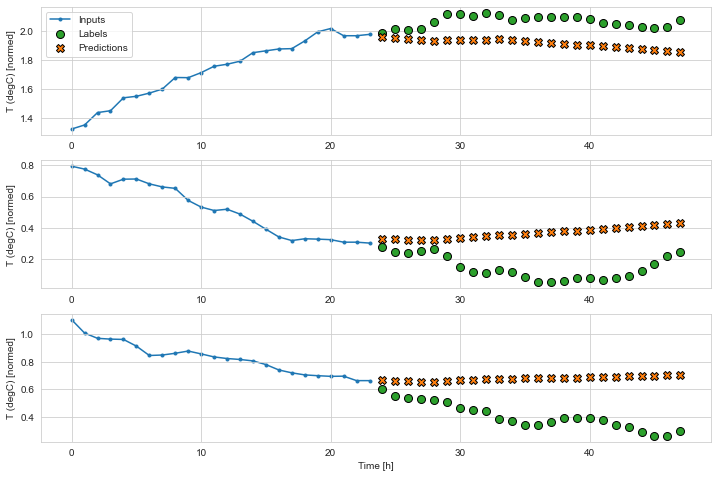

In [45]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

## Predicción

In [46]:
multi_dense_model.predict(input_predict_lstm)

array([[[ 1.3466825, -1.6322694,  1.9767615],
        [ 1.3421327, -1.636554 ,  1.9854702],
        [ 1.3386271, -1.6403421,  1.9938724],
        [ 1.3416796, -1.649595 ,  2.006778 ],
        [ 1.3369321, -1.654807 ,  2.0138333],
        [ 1.3375378, -1.6527704,  2.0144138],
        [ 1.3368287, -1.6559076,  2.0189407],
        [ 1.3362296, -1.6593076,  2.0224257],
        [ 1.3351362, -1.6570237,  2.0197086],
        [ 1.3329248, -1.6620932,  2.024416 ],
        [ 1.3302023, -1.6641444,  2.026735 ],
        [ 1.328032 , -1.6642069,  2.0263505],
        [ 1.3276012, -1.6654345,  2.0272007],
        [ 1.3285779, -1.6655997,  2.027149 ],
        [ 1.3258746, -1.6659794,  2.026624 ],
        [ 1.3189301, -1.6693437,  2.0276031],
        [ 1.312218 , -1.6743221,  2.0294042],
        [ 1.3082916, -1.6758943,  2.0286405],
        [ 1.3024759, -1.6794875,  2.0297232],
        [ 1.2993267, -1.6886324,  2.036753 ],
        [ 1.2984375, -1.6931964,  2.03928  ],
        [ 1.2963823, -1.7007746,  

# Convolucional 

La red MLP se basa únicamnente en el pasado reciente(último dato) para predecir el futuro. Un modelo convolucional hace predicciones basadas en un historial de ancho fijo, lo que puede conducir a un mejor rendimiento que el modelo denso, ya que puede ver cómo cambian las cosas con el tiempo, para este caso se toma los útimos 24 periodos:
<img src="CNN.png">


1314/1314 [==============================] - 2s 1ms/step - loss: 0.0236 - mean_absolute_error: 0.1023


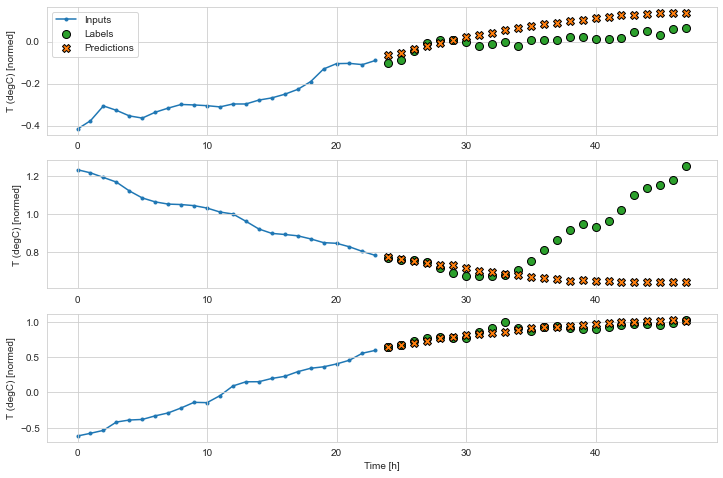

In [104]:
CONV_WIDTH = 24
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

# Predicción

In [105]:
multi_conv_model.predict(input_predict_lstm)

array([[[ 1.3030361, -1.5297089,  1.8510075],
        [ 1.2930214, -1.5447228,  1.866237 ],
        [ 1.2889901, -1.5546093,  1.8758492],
        [ 1.2785603, -1.561827 ,  1.88024  ],
        [ 1.2693417, -1.5607513,  1.8764795],
        [ 1.2650403, -1.564715 ,  1.8798254],
        [ 1.2596049, -1.5756412,  1.888633 ],
        [ 1.2555453, -1.5800923,  1.8908634],
        [ 1.2536099, -1.5784665,  1.8882911],
        [ 1.2524364, -1.5733293,  1.882713 ],
        [ 1.2537055, -1.5737755,  1.8823233],
        [ 1.249175 , -1.5720199,  1.8789636],
        [ 1.2479972, -1.5747453,  1.8799158],
        [ 1.2426267, -1.5744475,  1.8773681],
        [ 1.2376293, -1.5729418,  1.8745284],
        [ 1.2352773, -1.5735687,  1.8741463],
        [ 1.235489 , -1.5662953,  1.8659439],
        [ 1.2309407, -1.5527505,  1.8513695],
        [ 1.2264959, -1.54215  ,  1.8391848],
        [ 1.221684 , -1.5355595,  1.8304075],
        [ 1.2159817, -1.5265179,  1.8196994],
        [ 1.2111434, -1.5202085,  

# Red Neuronal Recurrente

Un modelo recurrente puede aprender a usar un largo historial de entradas, si es relevante para las predicciones que hace el modelo. Aquí el modelo acumulará el estado interno durante 24 horas, antes de hacer una sola predicción para las próximas 24 horas.

En este formato de disparo único, el LSTM solo necesita producir una salida en el último paso de tiempo, por lo tanto, establezca return_sequences=False en tf.keras.layers.LSTM .

<img src="RNNMutiple.png">

1314/1314 [==============================] - 7s 5ms/step - loss: 0.0209 - mean_absolute_error: 0.0918


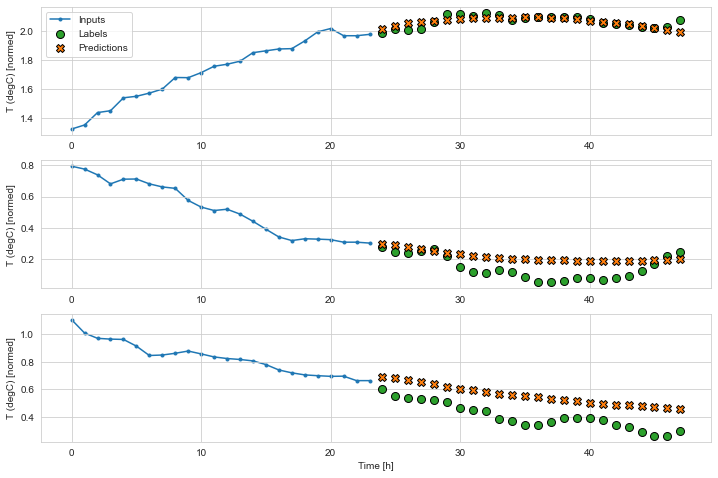

In [48]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

# Predicción

In [107]:
multi_lstm_model.predict(input_predict_lstm)

array([[[ 1.3352337, -1.6437275,  1.9622236],
        [ 1.329431 , -1.6508225,  1.9664065],
        [ 1.324375 , -1.6588155,  1.973053 ],
        [ 1.3201103, -1.6682832,  1.9817882],
        [ 1.3138127, -1.6791521,  1.990935 ],
        [ 1.306285 , -1.6903584,  1.9997311],
        [ 1.3049382, -1.7017248,  2.0095897],
        [ 1.2988143, -1.7169015,  2.0229192],
        [ 1.2907072, -1.7305566,  2.0344849],
        [ 1.2812239, -1.7429246,  2.0444674],
        [ 1.2735567, -1.7539101,  2.052694 ],
        [ 1.2655393, -1.7624738,  2.058619 ],
        [ 1.2576387, -1.7713938,  2.065249 ],
        [ 1.2515776, -1.7794026,  2.0709527],
        [ 1.2447416, -1.786087 ,  2.0752466],
        [ 1.2383293, -1.790186 ,  2.0773275],
        [ 1.231047 , -1.7959945,  2.0810814],
        [ 1.2252033, -1.8009087,  2.0842273],
        [ 1.2187682, -1.8042051,  2.085944 ],
        [ 1.2129512, -1.8054961,  2.0857127],
        [ 1.2075849, -1.8062463,  2.0848916],
        [ 1.2022344, -1.8075291,  

# Avanzado: modelo autorregresivo

Todos los modelos anteriores predicen la secuencia de salida completa en un solo paso.

En algunos casos, puede ser útil para el modelo descomponer esta predicción en pasos de tiempo individuales. Luego, la salida de cada modelo se puede retroalimentar en cada paso y se pueden hacer predicciones condicionadas a la anterior, como en el clásico Generating Sequences With Recurrent Neural Networks .

Una clara ventaja de este estilo de modelo es que se puede configurar para producir resultados con una longitud variable.

Puede tomar cualquiera de los modelos de salida múltiple de un solo paso entrenados en la primera mitad de este tutorial y ejecutarlo en un ciclo de retroalimentación autorregresivo, pero aquí se concentrará en crear un modelo que haya sido entrenado explícitamente para hacer eso.

<img src="ModeloAutoregresivoRNN.png">

En este caso, el modelo tiene que administrar manualmente las entradas para cada paso, por lo que usa tf.keras.layers.LSTMCell directamente para la interfaz de paso de tiempo único de nivel inferior.

In [108]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [109]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

El primer método que necesita este modelo es un método de warmup para inicializar su estado interno en función de las entradas. Una vez entrenado, este estado capturará las partes relevantes del historial de entrada. Esto es equivalente al modelo LSTM de un solo paso anterior:

In [110]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [111]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([64, 3])

Con el estado de RNN y una predicción inicial, ahora puede continuar iterando el modelo alimentando las predicciones en cada paso hacia atrás como entrada.

El enfoque más simple para recopilar las predicciones de salida es usar una lista de Python y un tf.stack después del bucle.

In [112]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [113]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (64, 24, 3)


Ahora, entrena el modelo:

1314/1314 [==============================] - 5s 4ms/step - loss: 0.0300 - mean_absolute_error: 0.1185


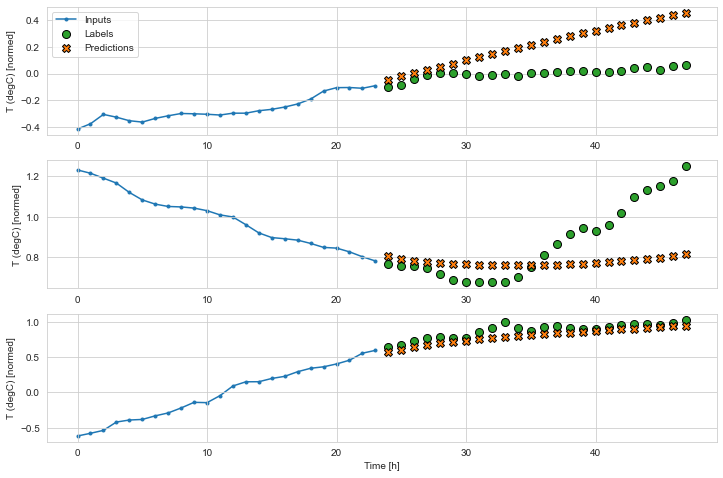

In [114]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

# Predicción

In [115]:
feedback_model.predict(input_predict_lstm)

array([[[ 1.305851 , -1.5406916,  1.8663206],
        [ 1.2955861, -1.5449237,  1.8691646],
        [ 1.2818258, -1.5462083,  1.8658774],
        [ 1.269246 , -1.546245 ,  1.8616549],
        [ 1.2565634, -1.5443394,  1.8554313],
        [ 1.2438838, -1.541002 ,  1.8477861],
        [ 1.2311743, -1.5365226,  1.8390222],
        [ 1.218461 , -1.53117  ,  1.8294276],
        [ 1.2057662, -1.5251493,  1.8192189],
        [ 1.1931111, -1.5186206,  1.8085638],
        [ 1.1805106, -1.511705 ,  1.7975873],
        [ 1.1679758, -1.5044936,  1.7863808],
        [ 1.1555101, -1.4970552,  1.7750105],
        [ 1.1431135, -1.4894406,  1.7635235],
        [ 1.1307819, -1.481687 ,  1.7519535],
        [ 1.1185085, -1.4738241,  1.7403237],
        [ 1.1062851, -1.4658743,  1.7286514],
        [ 1.0941025, -1.4578545,  1.7169495],
        [ 1.0819514, -1.44978  ,  1.7052277],
        [ 1.0698225, -1.4416625,  1.6934946],
        [ 1.0577071, -1.4335133,  1.6817567],
        [ 1.0455966, -1.4253426,  

# Rendimiento

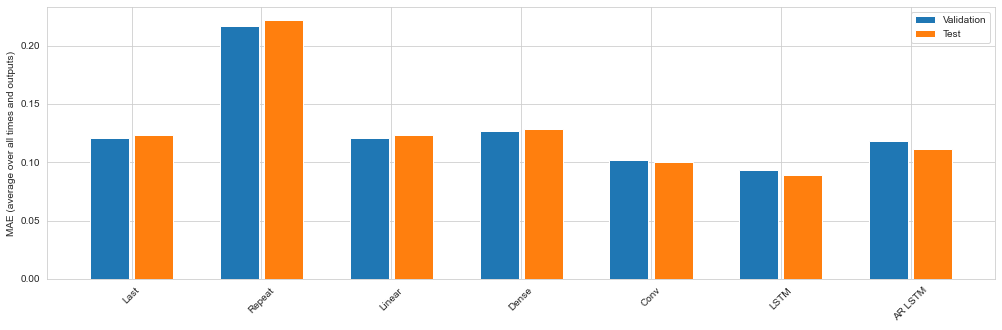

In [116]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

# Tuning o búsqueda de los hiperparámetros.

In [85]:
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers

# Bases de datos

Traemos la base de datos que se obtuvo del objeto del Windowgenerator y tomamos del conjunto de entrenamiento y validación, lo correspondiente a los inputs y targets de cada conjunto.

In [155]:
for batch in single_step_window.train.take(1):
    inputs_train,targets_train = batch

print("Input shape:", inputs_train.numpy().shape)
print("Target shape:", targets_train.numpy().shape)

Input shape: (64, 1, 3)
Target shape: (64, 1, 1)


In [153]:
for batch in single_step_window.val.take(1):
    inputs_val,targets_val = batch

print("Input shape:", inputs_val.numpy().shape)
print("Target shape:", targets_val.numpy().shape)

Input shape: (64, 1, 3)
Target shape: (64, 1, 1)


Se siguen los lineamientos en https://www.tensorflow.org/tutorials/keras/keras_tuner y https://keras.io/guides/keras_tuner/getting_started/

El modelo que configuró para el hiperajuste se denomina hipermodelo.

Puede definir un hipermodelo a través de dos enfoques:

* Mediante el uso de una función de generador de modelos
* HyperModel la clase HyperModel de la API Keras Tuner

In [184]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 10)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(1, activation="linear"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=["mean_squared_error"],
    )
    return model


build_model(kt.HyperParameters())

Después de definir el espacio de búsqueda, debemos seleccionar una clase de sintonizador para ejecutar la búsqueda. Puede elegir entre RandomSearch, BayesianOptimization e Hyperband, que corresponden a diferentes algoritmos de sintonización

In [185]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="",
    project_name="helloworld",
)

In [186]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [187]:
tuner.search(inputs_train, targets_train, epochs=20, validation_data=(inputs_val,targets_train))

Trial 3 Complete [00h 00m 06s]
val_loss: 0.8503292202949524

Best val_loss So Far: 0.8503292202949524
Total elapsed time: 00h 00m 16s
INFO:tensorflow:Oracle triggered exit


In [188]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(64, 1, 3))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (64, 3)                   0         
                                                                 
 dense (Dense)               (64, 64)                  256       
                                                                 
 dense_1 (Dense)             (64, 416)                 27040     
                                                                 
 dense_2 (Dense)             (64, 384)                 160128    
                                                                 
 dense_3 (Dense)             (64, 128)                 49280     
                                                                 
 dense_4 (Dense)             (64, 32)                  4128      
                                                                 
 dropout (Dropout)           (64, 32)                  0

In [189]:
tuner.results_summary()

Results summary
Results in ./helloworld
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 5
units_0: 64
activation: relu
dropout: True
lr: 0.0002119225054468749
units_1: 416
units_2: 384
units_3: 128
units_4: 32
Score: 0.8503292202949524
Trial summary
Hyperparameters:
num_layers: 4
units_0: 128
activation: relu
dropout: False
lr: 0.00046565855133472715
units_1: 32
units_2: 32
units_3: 32
Score: 0.8782328963279724
Trial summary
Hyperparameters:
num_layers: 4
units_0: 320
activation: tanh
dropout: True
lr: 0.0010062870411529313
units_1: 288
units_2: 64
units_3: 256
Score: 1.0693715810775757


In [191]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
inputs_all = tf.concat([inputs_train, inputs_val],0)
targets_all = tf.concat([targets_train, targets_val],0)
model.fit(x=inputs_all, y=targets_all, epochs=20)

Epoch 1/20
4/4 [==============================] - 0s 5ms/step - loss: 0.7984 - mean_squared_error: 0.7984
Epoch 2/20
4/4 [==============================] - 0s 5ms/step - loss: 0.5761 - mean_squared_error: 0.5761
Epoch 3/20
4/4 [==============================] - 0s 5ms/step - loss: 0.4362 - mean_squared_error: 0.4362
Epoch 4/20
4/4 [==============================] - 0s 5ms/step - loss: 0.3057 - mean_squared_error: 0.3057
Epoch 5/20
4/4 [==============================] - 0s 5ms/step - loss: 0.1863 - mean_squared_error: 0.1863
Epoch 6/20
4/4 [==============================] - 0s 5ms/step - loss: 0.1425 - mean_squared_error: 0.1425
Epoch 7/20
4/4 [==============================] - 0s 7ms/step - loss: 0.0727 - mean_squared_error: 0.0727
Epoch 8/20
4/4 [==============================] - 0s 6ms/step - loss: 0.1031 - mean_squared_error: 0.1031
Epoch 9/20
4/4 [==============================] - 0s 4ms/step - loss: 0.0737 - mean_squared_error: 0.0737
Epoch 10/20
4/4 [=============================